In [52]:
import pandas as pd
import seaborn as sns

from scipy import stats

from database_session.database_session import GetDataSession

## Get Data

In [2]:
DATABASE_PATH = "../database/hockey_v12.db"

In [3]:
db_session = GetDataSession(db_path=DATABASE_PATH)
db_session.set_up_connection()
data = db_session.get_db_query(query_name="draft_data")
df = pd.DataFrame(data, columns=[
    'player_id', 'player_name', 'regular_season', 'team_id', 'team_name', 'season', 'games_played', 'g', 'a', 'tp', 'plus_minus', 'draft_position', 'draft_round', 'draft_year'])
df = df.drop_duplicates(subset=['player_id', 'player_name', 'regular_season', 'team_id', 'team_name', 'season', 'games_played', 'g', 'a', 'tp', 'plus_minus'])

INFO: New scrapping session started
INFO: New DB session initiated with db at ../database/hockey_v12.db


In [9]:
df

,player_id,player_name,regular_season,team_id,team_name,season,games_played,g,a,tp,plus_minus,draft_position,draft_round,draft_year
0,1525,Pete Mahovlich,False,87,Detroit Red Wings,1965-1966,NaN,NaN,NaN,NaN,NaN,2,1,1963
1,1525,Pete Mahovlich,True,87,Detroit Red Wings,1965-1966,3.0,0.0,1.0,1.0,NaN,2,1,1963
2,1538,Jim McKenny,False,144,Toronto Maple Leafs,1965-1966,NaN,NaN,NaN,NaN,NaN,17,3,1963
3,1538,Jim McKenny,True,144,Toronto Maple Leafs,1965-1966,2.0,0.0,0.0,0.0,NaN,17,3,1963
4,1525,Pete Mahovlich,False,87,Detroit Red Wings,1966-1967,NaN,NaN,NaN,NaN,NaN,2,1,1963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70939,8261,Nicolas Meloche,True,45,Columbus Blue Jackets,2023-2024,NaN,NaN,NaN,NaN,NaN,40,2,2015
70940,17937,Nate Schnarr,False,45,Columbus Blue Jackets,2023-2024,NaN,NaN,NaN,NaN,NaN,75,3,2017
70941,17937,Nate Schnarr,True,45,Columbus Blue Jackets,2023-2024,NaN,NaN,NaN,NaN,NaN,75,3,2017
70942,24306,Leo Carlsson,False,5466,Anaheim Ducks,2023-2024,NaN,NaN,NaN,NaN,NaN,2,1,2023


## Preprocess Data

In [36]:
player_stats = df.groupby(['player_id', 'player_name', 'season'], as_index=False)[["games_played","g", "a", "tp", "plus_minus"]].sum()
draft_info = df[['player_id', 'player_name', 'draft_position', 'draft_round', 'draft_year']]
player_stats = pd.merge(player_stats, draft_info, on='player_id')
player_stats.sort_values(by='tp', ascending=False)

player_stats_overall = df.groupby(['player_id', 'player_name'], as_index=False)[["games_played","g", "a", "tp", "plus_minus"]].sum()
player_stats_overall = pd.merge(player_stats_overall, draft_info, on='player_id')

In [42]:
active_players = df.loc[df['season']=='2023-2024', 'player_id'].to_list()
non_active_players = list(set(df['player_id'].to_list()) - set(active_players))

[2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 1525,
 1538,
 1588,
 1610,
 1621,
 1644,
 1653,
 1655,
 1670,
 1671,
 1674,
 1679,
 1681,
 1682,
 1683,
 1684,
 1691,
 1692,
 1695,
 1700,
 1706,
 1709,
 1733,
 1734,
 1737,
 1741,
 1743,
 1745,
 1747,
 1748,
 1749,
 1750,
 1751,
 1752,
 1758,
 1760,
 1761,
 1763,
 1765,
 1766,
 1771,
 1772,
 1782,
 1783,
 1791,
 1792,
 1793,
 1796,
 1798,
 1799,
 1800,
 1802,
 1803,
 1806,
 1807,
 1812,
 1813,
 1814,
 1816,
 1818,
 1819,
 1820,
 1822,
 1826,
 1827,
 1829,
 1831,
 1836,
 1837,
 1841,
 1842,
 1843,
 1847,
 1849,
 1850,
 1852,
 1867,
 1868,
 1869,
 1870,
 1871,
 1874,
 1875,
 1876,
 1877,
 1878,
 1879,
 1881,
 1884,
 1886,
 1887,
 1888,
 1889,
 1890,
 1891,
 1892,
 1893,
 1895,
 1897,
 1898,
 1899,
 1901,
 1902,
 1906,
 1907,
 1908,
 1909,
 1910,
 1911,
 1912,
 1913,
 1916,
 1917,
 1929,
 1930,
 1931,
 1933,
 1934,
 1935,
 1937,
 1938,
 1939,
 1940,
 1941,
 1942,
 1943,
 1944,
 1945,
 1946,
 1948,
 1949,
 1950,
 1951,
 1953,
 1954,
 1956,
 1958,
 1960,
 1

## Analysis

In [46]:
filter_draft = (player_stats_overall['draft_year'] >= 2005)&(player_stats_overall['player_id'].isin(non_active_players))

### Average Career Matches Played Based Round Drafted

INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='draft_round', ylabel='games_played'>

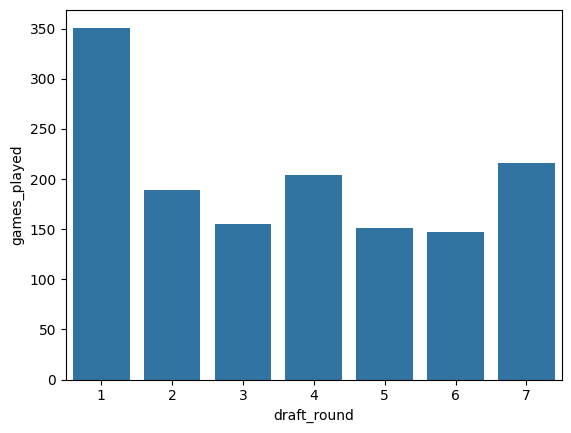

In [51]:
player_stats_overall
draft_mean_games = player_stats_overall[filter_draft].groupby("draft_round").agg(
    games_played=("games_played", "median")).reset_index()
sns.barplot(draft_mean_games, x="draft_round", y="games_played")

## Does Difference between Rounds Drafted with exception of First Round matter?

## Average Career Matches Played Based on Position Drafted

INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='draft_position', ylabel='games_played'>

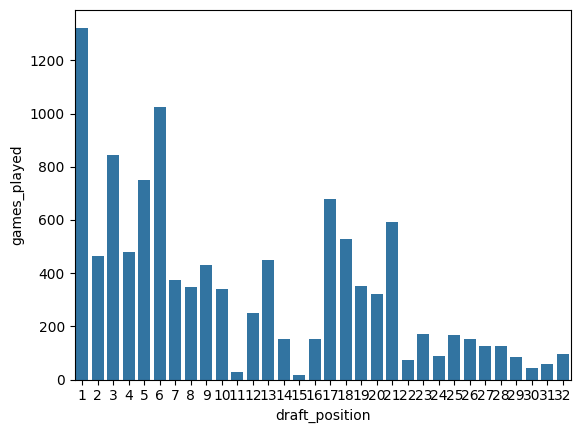

In [50]:
draft_mean_games = player_stats_overall[(filter_draft)&(player_stats_overall['draft_position'] <=32)].groupby("draft_position").agg(
    games_played=("games_played", "median")).reset_index()
sns.barplot(draft_mean_games, x="draft_position", y="games_played")